# Imports

In [61]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Conexao com o Banco

In [2]:
con = sqlite3.connect('../data/if.db')

# Questao 1

In [17]:
df_questao1 = pd.read_sql("""
  with tb_sessoes_providers as (

    select 
        provider,
        count(distinct session_id) as count_sessoes,
        status

    from
        biometry_execution

    group by 
        provider,
        status

),

tb_total_sessoes as (

    select
        provider,
        sum(count_sessoes) as total_sessoes
    from
        tb_sessoes_providers 
    group by
        provider

)

select 
    tp.provider,
    tp.status,
    tp.count_sessoes,
    ts.total_sessoes,
    ((cast(tp.count_sessoes as float)/ ts.total_sessoes) * 100) as perc_providers 



from
    tb_sessoes_providers tp
inner join 
    tb_total_sessoes ts on tp.provider = ts.provider
"""
, con)


In [20]:
df_questao1

,provider,status,count_sessoes,total_sessoes,perc_providers
0,A,MATCH,399,497,80.281690
1,A,NOT_MATCH,58,497,11.670020
2,A,PROVIDER_FAILED,40,497,8.048290
3,B,MATCH,28,40,70.000000
4,B,NOT_MATCH,4,40,10.000000
5,B,PROVIDER_FAILED,8,40,20.000000
6,C,MATCH,6,9,66.666667
7,C,PROVIDER_FAILED,3,9,33.333333


C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\1921016025.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Status')
C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\1921016025.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  leg_handles = [plt.Rectangle((0,0),1,1, color=cores[i], edgecolor='k') for i in range(len(cores))]


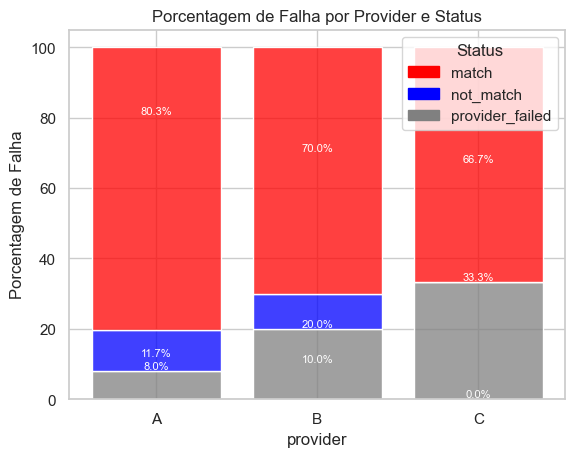

In [113]:
# Construcao do grafico de barras empilhado
cores = ['red', 'blue', 'gray']
ax = sns.histplot(df_questao1, x='provider', hue='status', weights='perc_providers',
             multiple='stack', palette=cores, shrink=0.8, stat='count')

ax.set_ylabel('Porcentagem de Falha')
ax.set_title('Porcentagem de Falha por Provider e Status')
ax.legend(title='Status')

leg_handles = [plt.Rectangle((0,0),1,1, color=cores[i], edgecolor='k') for i in range(len(cores))]
leg_labels = ['match', 'not_match', 'provider_failed']
ax.legend(leg_handles, leg_labels, title='Status')

# Gerando as porcentagens para cada barra
for container in ax.containers:
    for p in container.patches:
        percentage_text = f"{p.get_height() :.1f}%"
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(
            percentage_text,
            (x, y),
            ha='center',
            va='bottom',
            color='white',
            fontsize=8,
            xytext=(0, 0),  
            textcoords='offset points',  
        )





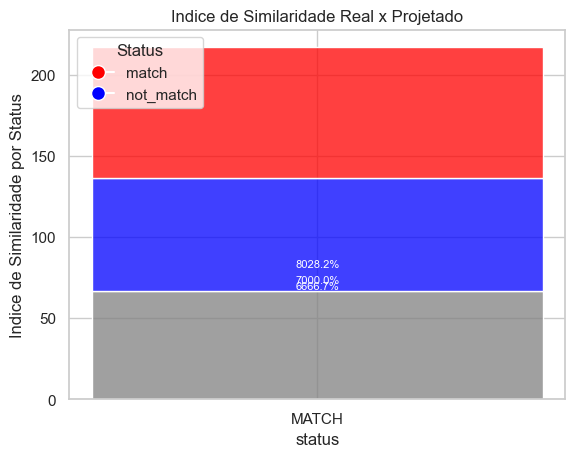

In [123]:
cores = ['red', 'blue', 'gray']
ax = sns.histplot(df_questao1[df_questao1['status']== 'MATCH'], x='status', hue='provider',
                  weights='perc_providers', multiple='stack',
                  palette=cores, shrink=0.8, stat='count')

ax.set_ylabel('Indice de Similaridade por Status')
ax.set_title('Indice de Similaridade Real x Projetado')

# Personalizando a legenda
custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='match'),
                 plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='not_match')]

ax.legend(handles=custom_legend, title='Status', loc='upper left')

# Adicionando os percentuais nas barras
for container in ax.containers:
    for p in container.patches:
        percentage_text = f"{p.get_height() * 100:.1f}%"
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(
            percentage_text,
            (x, y),
            ha='center',
            va='bottom',
            color='white',
            fontsize=8,
            xytext=(0, 0),
            textcoords='offset points',
        )

plt.show()


# Questao 2

In [6]:
df_questao2 = pd.read_sql("""
   select 
    d.Category,
    count(d.Driver_ID) as count_drivers

    from biometry as b
    left join drivers as d on b.Driver_ID = d.Driver_ID
    where status = 'NOT_MATCH'
    group by Category
    order by count(d.Driver_ID) desc

"""
, con)


In [7]:
df_questao2

,Category,count_drivers
0,Bronze,25
1,Prata,20
2,Iniciante,11
3,Ouro,4
4,Diamante,1


C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\3347901202.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\3347901202.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


Text(0, 0.5, 'Categoria de Entregador')

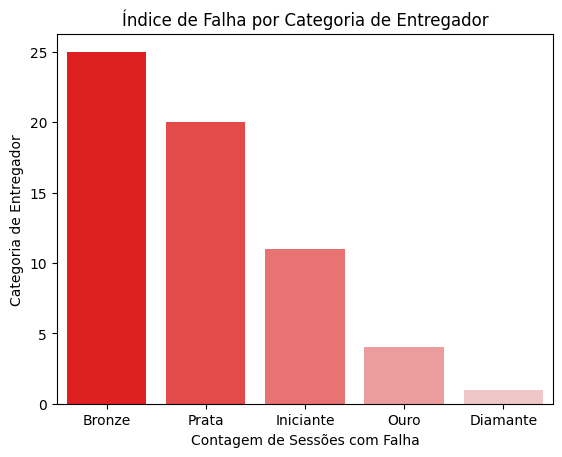

In [8]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


plt.title('Índice de Falha por Categoria de Entregador')
plt.xlabel('Contagem de Sessões com Falha')
plt.ylabel('Categoria de Entregador')


# Questao 3

In [92]:
df_questao3 = pd.read_sql("""
 WITH tb_similaridade_max AS (
    SELECT
        session_id,
        MAX(similarity) AS max_similaridade
    FROM
        biometry_execution
    GROUP BY
        session_id
),

-- Tabela que calcula a similaridade acima de 0.8

tb_similaridade_real AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS status,
        'similaridade_real' AS similaridade_real
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            ELSE 'not_match' 
        END

),

-- Tabela que calcula o indice de match para sessoes com similaridade superior a 0.8

tb_indice_similaridade_real as (
    SELECT
        status,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'similaridade_real' as classificacao
        

    FROM 
        tb_similaridade_real
    GROUP BY
        status
),

-- Tabela que calcula a similaridade acima de 0.9

tb_similaridade_projetada AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS status,
        'projetada' AS tipo
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            ELSE 'not_match' 
        END
),

-- Tabela que calcula o indice de match para sessoes com similaridade superior a 0.9

tb_indice_similaridade_projetada as (
    SELECT
        status,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'similaridade_projetada' as classificacao
        

    FROM 
        tb_similaridade_projetada
    GROUP BY
        status
)

-- Tabela que faz a juncao da tabela de indice de match superior a 0.8 com a tabela de indice de match superior a 0.9

select * from tb_indice_similaridade_real

union

select * from tb_indice_similaridade_projetada 

"""
, con)


In [93]:
df_questao3

,status,count_session_id,total_sessoes,indice_similaridade,classificacao
0,match,281,497,0.565392,similaridade_projetada
1,match,432,497,0.869215,similaridade_real
2,not_match,65,497,0.130785,similaridade_real
3,not_match,216,497,0.434608,similaridade_projetada


C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\1175984649.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(df_questao3, x='classificacao', hue='status',


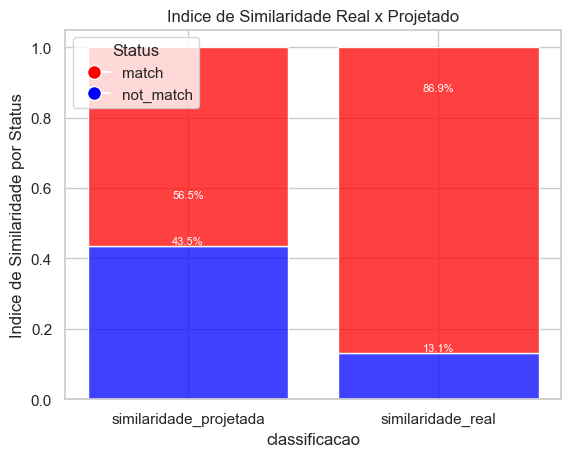

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

cores = ['red', 'blue', 'gray']
ax = sns.histplot(df_questao3, x='classificacao', hue='status',
                  weights='indice_similaridade', multiple='stack',
                  palette=cores, shrink=0.8, stat='count')

ax.set_ylabel('Indice de Similaridade por Status')
ax.set_title('Indice de Similaridade Real x Projetado')

custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='match'),
                 plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='not_match')]

ax.legend(handles=custom_legend, title='Status', loc='upper left')

for container in ax.containers:
    for p in container.patches:
        percentage_text = f"{p.get_height() * 100:.1f}%"
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(
            percentage_text,
            (x, y),
            ha='center',
            va='bottom',
            color='white',
            fontsize=8,
            xytext=(0, 0),
            textcoords='offset points',
        )

plt.show()


# Questao 4

In [101]:
df_questao4 = pd.read_sql("""

select 
    b.status,
    count(distinct(o.Order_ID)) as count_order,
    count(distinct(d.Driver_ID)) as count_drivers,
    1.0* count(distinct(o.Order_ID)) / count(distinct(d.Driver_ID)) as pedidos_cancelados_por_driver

from 
    orders as o
left join 
    drivers as d on o.Driver_ID = d.Driver_ID
left join 
    biometry as b on d.Driver_ID = b.Driver_ID

where 
    o.Order_Status = 'CANCELLED'
group by 
    b.status
order by 
    1.0* count(distinct(o.Order_ID)) / count(distinct(d.Driver_ID)) desc
"""
, con)


In [102]:
df_questao4

,Status,count_order,count_drivers,pedidos_cancelados_por_driver
0,NOT_MATCH,137,51,2.686275
1,MATCH,888,365,2.432877
2,None,412,175,2.354286
3,PROVIDER_FAILED,7,3,2.333333


C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\396125603.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Status', y='pedidos_cancelados_por_driver', data=df_questao4, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_22288\396125603.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Status', y='pedidos_cancelados_por_driver', data=df_questao4, palette=custom_palette)


Text(0, 0.5, 'Pedidos Cancelados por Entregador')

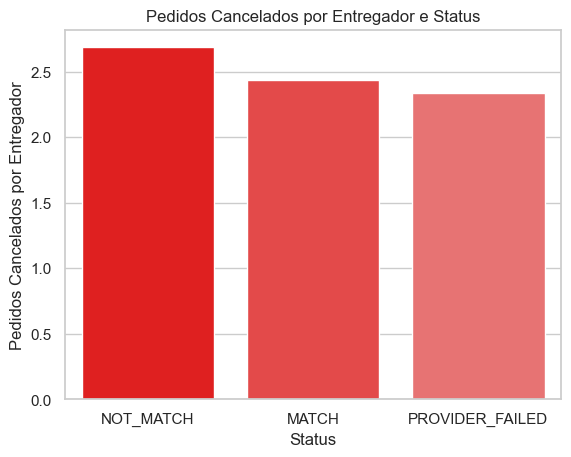

In [105]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Status', y='pedidos_cancelados_por_driver', data=df_questao4, palette=custom_palette)


plt.title('Pedidos Cancelados por Entregador e Status')
plt.xlabel('Status')
plt.ylabel('Pedidos Cancelados por Entregador')

<Axes: >

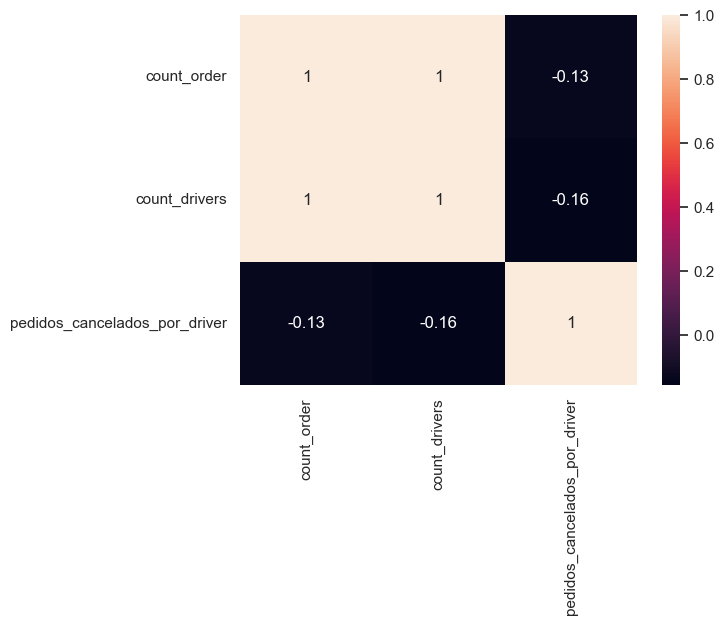

In [108]:
df_questao4_corr = df_questao4[['count_order','count_drivers','pedidos_cancelados_por_driver']]
sns.heatmap(df_questao4_corr.corr(method='pearson'),annot=True)

# Questao 5

In [78]:
df_questao5 = pd.read_sql("""


WITH tb_acesso_negados_por_dia AS (
    SELECT 
        Event_Dt,
        COUNT(Session_ID) AS acessos_negados
    FROM
        biometry_execution
    WHERE 
        status = 'NOT_MATCH'
    GROUP BY
        Event_Dt
),

-- Tabela que calcula a media de acessos negados 


tb_media_acessos_negados_por_dia AS (
    SELECT
        Event_Dt,
        acessos_negados,
        round(AVG(acessos_negados) OVER (),0) as media_acessos
    FROM 
        tb_acesso_negados_por_dia
)

SELECT 
    Event_Dt,
    acessos_negados,
    media_acessos
FROM 
    tb_media_acessos_negados_por_dia
ORDER BY 
    Event_Dt ASC;

"""
, con)


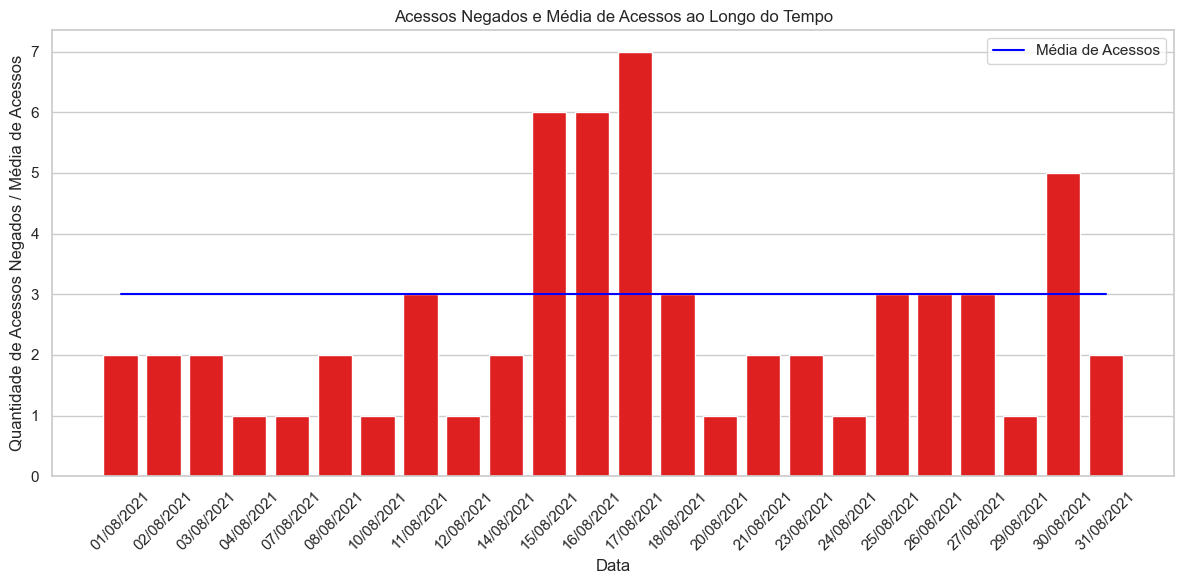

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

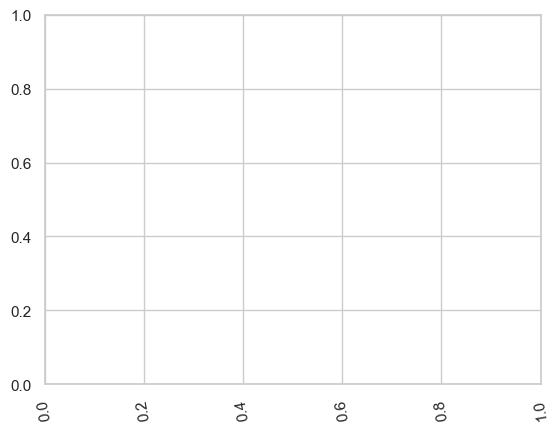

In [118]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='Event_Dt', y='acessos_negados', data=df_questao5, color='red')
sns.lineplot(x='Event_Dt', y='media_acessos', data=df_questao5, color='blue', label='Média de Acessos')

plt.xticks(rotation=45)

plt.title('Acessos Negados e Média de Acessos ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acessos Negados / Média de Acessos')

plt.legend()
plt.tight_layout()
plt.show()
plt.xticks(rotation=100)
